In [1]:
import pylab as pl
import pandas as pd
import numpy as np
import os
import scipy.stats
from sklearn.cluster import KMeans
pl.style.use('fivethirtyeight')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Converting from 2000 to 2010 Census Blocks

In [2]:
block_relate = pd.read_csv('data/TAB2000_TAB2010_ST_36_v2.txt', dtype=object)

In [3]:
block_relate = block_relate[['STATE_2000', 'COUNTY_2000', 'TRACT_2000', 'BLK_2000', 
                             'STATE_2010', 'COUNTY_2010', 'TRACT_2010', 'BLK_2010']]

In [4]:
block_relate.head(3)

,STATE_2000,COUNTY_2000,TRACT_2000,BLK_2000,STATE_2010,COUNTY_2010,TRACT_2010,BLK_2010
0,36,001,000100,1999,36,001,000100,1000
1,36,001,000100,1000,36,001,000100,1001
2,36,001,000100,1001,36,001,000100,1002


In [5]:
block_relate = block_relate[(block_relate['COUNTY_2000'] == '005') |
                            (block_relate['COUNTY_2000'] == '047') | 
                            (block_relate['COUNTY_2000'] == '061') | 
                            (block_relate['COUNTY_2000'] == '081') | 
                            (block_relate['COUNTY_2000'] == '085')]

In [6]:
block_relate.shape

(41082, 8)

In [7]:
block_relate['2000_block'] = block_relate['STATE_2000'] + block_relate['COUNTY_2000'] + block_relate['TRACT_2000'] + block_relate['BLK_2000']
block_relate['2010_block'] = block_relate['STATE_2010'] + block_relate['COUNTY_2010'] + block_relate['TRACT_2010'] + block_relate['BLK_2010']

In [8]:
block_relate = block_relate[['2000_block', '2010_block']]

In [9]:
block_relate['2000_block'] = block_relate['2000_block'].astype(int64)
block_relate['2010_block'] = block_relate['2010_block'].astype(int64)

In [10]:
block_relate.head(3)

,2000_block,2010_block
12429,360050001009999,360050001000001
12430,360050001009999,360050001000002
12431,360050001009000,360050001001000


# Reading, cleaning, and merging

In [11]:
# read in OD 2002 data
od = pd.read_csv(os.path.expandvars('data/ny_od_main_JT00_2002.csv.gz'), compression = 'gzip')

In [12]:
# convert w_geocode to 2010 census block
od_2002 = pd.merge(od, block_relate, left_on='w_geocode', right_on='2000_block', how='inner')

In [13]:
# cut relevant columns 
od_2002 = od_2002[['h_geocode', '2010_block', 'S000']]

In [14]:
# rename
od_2002.columns = ['h_geocode', 'w_geocode', 'S000']

In [15]:
# convert h_geocode to 2010 census block
od_2002 = pd.merge(od_2002, block_relate, left_on='h_geocode', right_on='2000_block', how='inner')

In [16]:
# cut relevant columns 
od_2002= od_2002[['w_geocode', '2010_block', 'S000']]

In [17]:
# rename
od_2002.columns = ['w_geocode', 'h_geocode', 'S000']

In [18]:
od_2002.head(5)

,w_geocode,h_geocode,S000
0,360050002001000,360050041002001,1
1,360050033001000,360050041002001,1
2,360050039001001,360050041002001,1
3,360050039002001,360050041002001,1
4,360050039003000,360050041002001,1


In [19]:
# read in geography crosswalk data
geoxwalk = pd.read_csv(os.path.expandvars('data/ny_xwalk.csv.gz'), compression = 'gzip')

/Users/Erwan/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (27,28,29,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
# limit crosswalk data to NYC
geoxwalk_nyc = geoxwalk[(geoxwalk.ctyname == 'Bronx County, NY') |
                           (geoxwalk.ctyname == 'Kings County, NY') |
                           (geoxwalk.ctyname == 'Queens County, NY') |
                           (geoxwalk.ctyname == 'New York County, NY') |
                           (geoxwalk.ctyname == 'Richmond County, NY')]

# limit crosswalk data to block code and census tract
geoxwalk_nyc = geoxwalk_nyc[['tabblk2010', 'trct']]

In [21]:
# merge OD data with crosswalk data as 'inner' join so that only OD data within NYC are stored
# two joins are required (I think) to join on both h_geocode and w_geocode
merge_result = pd.merge(od_2002, geoxwalk_nyc, left_on='h_geocode', right_on='tabblk2010', how='inner')
merge_result = pd.merge(merge_result, geoxwalk_nyc, left_on='w_geocode', right_on='tabblk2010', how='inner')

In [22]:
# limit OD data to jobs and census tracts, rename accordingly
merge_result = merge_result[['trct_x', 'trct_y', 'S000']]
merge_result.columns = ['h_trct', 'w_trct', 0]

In [23]:
# group OD data by census tract
grouped = merge_result.groupby((merge_result['h_trct'], merge_result['w_trct']))

In [24]:
# create lists for each column
od_dict = {}
od_dict['h_trct'] = []
od_dict['w_trct'] = []
od_dict[0] = []

In [25]:
# iterate through grouped OD data and append information to relevant lists
for k, group in grouped:
    od_dict['h_trct'].append(k[0]) 
    od_dict['w_trct'].append(k[1])
    od_dict[0].append(group[0].sum())

In [26]:
# create new dataframe from completed lists
od = pd.DataFrame.from_dict(od_dict, orient = 'columns')

In [27]:
# create list of remaining OD data to read
list1 = ['data/ny_od_main_JT00_2003.csv.gz', 'data/ny_od_main_JT00_2004.csv.gz', 'data/ny_od_main_JT00_2005.csv.gz', 'data/ny_od_main_JT00_2006.csv.gz', 'data/ny_od_main_JT00_2007.csv.gz', 'data/ny_od_main_JT00_2008.csv.gz', 'data/ny_od_main_JT00_2009.csv.gz']

for i in range(0,len(list1)):
    # read OD data from index i of list1
    od_temp = pd.read_csv(os.path.expandvars(list1[i]), compression = 'gzip')
    
    # convert w_geocode to 2010 census block
    od_convert = pd.merge(od_temp, block_relate, left_on='w_geocode', right_on='2000_block', how='inner')
    
    # cut relevant columns 
    od_convert = od_convert[['h_geocode', '2010_block', 'S000']]
    
    # rename
    od_convert.columns = ['h_geocode', 'w_geocode', 'S000']
    
    # convert h_geocode to 2010 census block
    od_convert = pd.merge(od_convert, block_relate, left_on='h_geocode', right_on='2000_block', how='inner')
    
    # cut relevant columns 
    od_convert = od_convert[['w_geocode', '2010_block', 'S000']]
    
    # rename
    od_convert.columns = ['w_geocode', 'h_geocode', 'S000']
    
    # merge OD data with crosswalk data as 'inner' join so that only OD data within NYC is stored
    merge_result = pd.merge(od_convert, geoxwalk_nyc, left_on='h_geocode', right_on='tabblk2010', how='inner')
    merge_result = pd.merge(merge_result, geoxwalk_nyc, left_on='w_geocode', right_on='tabblk2010', how='inner')
    
    # limit OD data to jobs and census tracts, rename accordingly
    merge_result = merge_result[['trct_x', 'trct_y', 'S000']]
    merge_result.columns = ['h_trct', 'w_trct', i+1]
    
    # group OD data by census tract
    grouped = merge_result.groupby((merge_result['h_trct'], merge_result['w_trct']))
    
    # create lists for each column
    od_dict = {}
    od_dict['h_trct'] = []
    od_dict['w_trct'] = []
    od_dict[i+1] = []
    
    # iterate through grouped OD data and append information to relevant lists
    for k, group in grouped:
        od_dict['h_trct'].append(k[0]) 
        od_dict['w_trct'].append(k[1])
        od_dict[i+1].append(group[i+1].sum())
        
    # create new dataframe from completed dictionary
    od_temp = pd.DataFrame.from_dict(od_dict, orient = 'columns')
    
    # join od with od_temp
    od = pd.merge(od, od_temp, how = 'outer', on=['h_trct', 'w_trct'])

In [28]:
# create list of remaining OD data to read
list2 = ['data/ny_od_main_JT00_2010.csv.gz', 'data/ny_od_main_JT00_2011.csv.gz', 'data/ny_od_main_JT00_2012.csv.gz', 'data/ny_od_main_JT00_2013.csv.gz']

for i in range(0,len(list2)):
    # read OD data from index i of list1
    od_temp = pd.read_csv(os.path.expandvars(list2[i]), compression = 'gzip')
    
    # merge OD data with crosswalk data as 'inner' join so that only OD data within NYC is stored
    merge_result = pd.merge(od_temp, geoxwalk_nyc, left_on='h_geocode', right_on='tabblk2010', how='inner')
    merge_result = pd.merge(merge_result, geoxwalk_nyc, left_on='w_geocode', right_on='tabblk2010', how='inner')
    
    # limit OD data to jobs and census tracts, rename accordingly
    merge_result = merge_result[['trct_x', 'trct_y', 'S000']]
    merge_result.columns = ['h_trct', 'w_trct', i+8]
    
    # group OD data by census tract
    grouped = merge_result.groupby((merge_result['h_trct'], merge_result['w_trct']))
    
    # create lists for each column
    od_dict = {}
    od_dict['h_trct'] = []
    od_dict['w_trct'] = []
    od_dict[i+8] = []
    
    # iterate through grouped OD data and append information to relevant lists
    for k, group in grouped:
        od_dict['h_trct'].append(k[0]) 
        od_dict['w_trct'].append(k[1])
        od_dict[i+8].append(group[i+8].sum())
        
    # create new dataframe from completed dictionary
    od_temp = pd.DataFrame.from_dict(od_dict, orient = 'columns')
    
    # join od with od_temp
    od = pd.merge(od, od_temp, how = 'outer', on=['h_trct', 'w_trct'])

# Clustering OD data

In [29]:
od.shape

(1920196, 14)

In [30]:
# replace all NaN values with 0
# this is a huge assumption on my part, and we might want to discuss whether or not this is prudent
od = od.fillna(0)

# set a threshold of 25 jobs over the course of 12 years, so as to take a substantive sample
# 25 was chosen very arbitrarily and might be a bad value, again we should discuss this
od_cut = od[(od[0] + od[1] + od[2] + od[3] + od[4] + od[5] + od[6] + od[7] + od[8] + od[9] + od[10] + od[11]) > 25]

In [31]:
od_cut.shape

(166138, 14)

In [32]:
# limit OD data to jobs
od_cut_jobs = od_cut[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]

In [33]:
matrix = od_cut_jobs.as_matrix()

In [34]:
matrix.shape

(166138, 12)

In [35]:
# Standardize Rows
matrix = matrix - matrix.mean(axis=1)[:,None]
matrix = matrix / matrix.std(axis=1)[:,None]

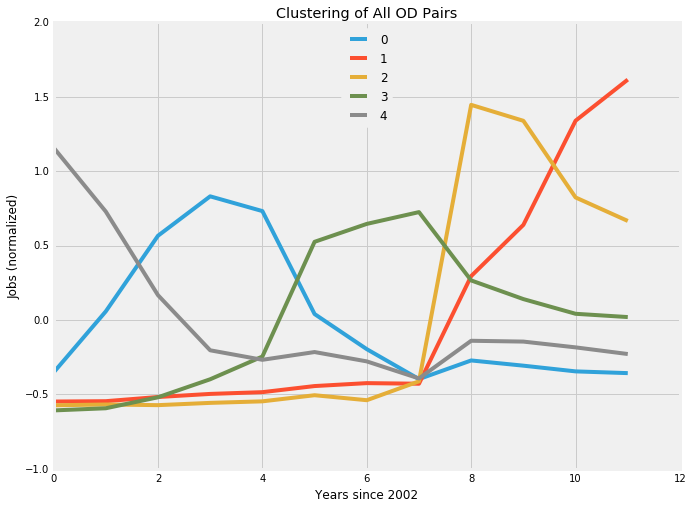

In [36]:
# perform clustering and plotting
fig = pl.figure(figsize=(10, 8))
pl.title('Clustering of All OD Pairs')
pl.xlabel('Years since 2002')
pl.ylabel('Jobs (normalized)')

kmeans = KMeans(n_clusters=5)
kmeans.fit(matrix)
for i in range(5):
    pl.plot(kmeans.cluster_centers_[i], label = i)
    
pl.legend(loc='upper center')

In [37]:
od_cut['cluster'] = kmeans.labels_

/Users/Erwan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [38]:
od_cut.to_csv('od_cut_all.csv')

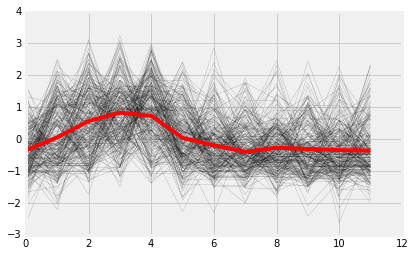

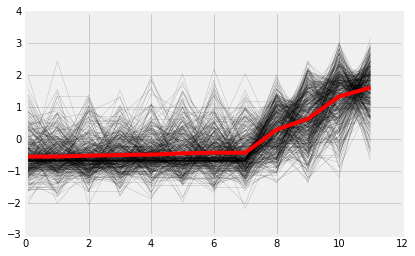

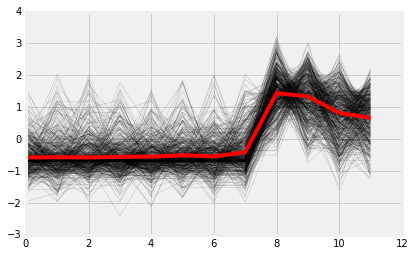

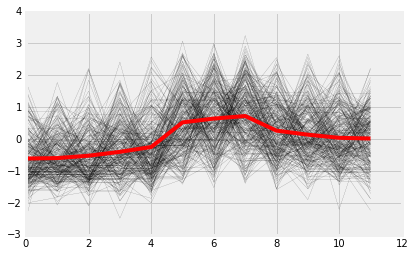

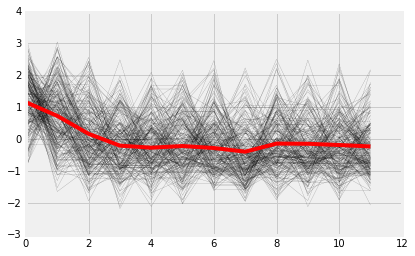

In [39]:
for j in range(kmeans.n_clusters):
    index = kmeans.labels_ == j
    pl.figure()
    for ii in range (0, len(matrix), 100):
        if index[ii] == True:   
            pl.plot(matrix[ii], color = 'k', lw = 0.1)
    pl.plot(kmeans.cluster_centers_[j], color = 'red')

# Generate clusters on random data

In [40]:
test_od = pd.DataFrame(np.random.randint(0,1000,size=(150000, 12)), columns=list('ABCDEFGHIJKL'))

In [41]:
matrix_test = test_od.as_matrix()

In [42]:
matrix_test.shape

(150000, 12)

In [43]:
# Standardize Rows
matrix_test = matrix_test - matrix_test.mean(axis=1)[:,None]
matrix_test = matrix_test / matrix_test.std(axis=1)[:,None]

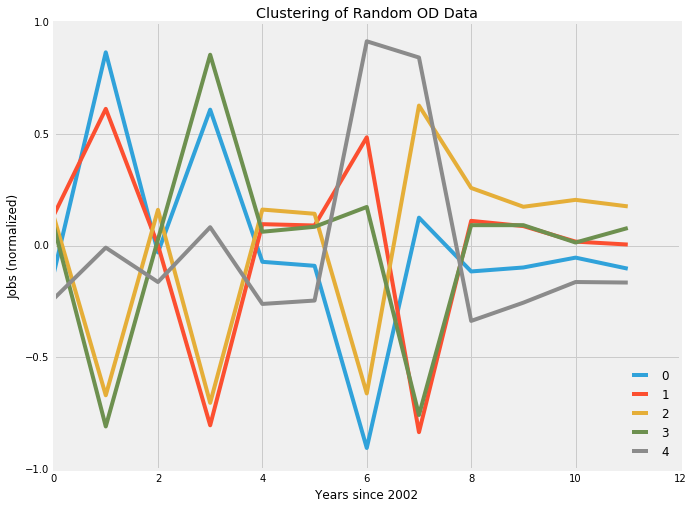

In [53]:
# perform clustering and plotting
fig = pl.figure(figsize=(10, 8))
pl.title('Clustering of Random OD Data (5 clusters)')
pl.xlabel('Years since 2002')
pl.ylabel('Jobs (normalized)')

kmeans = KMeans(n_clusters=5)
kmeans.fit(matrix_test)
for i in range(5):
    pl.plot(kmeans.cluster_centers_[i], label = i)
    
pl.legend(loc='lower right')

# 10 clusters for clarity

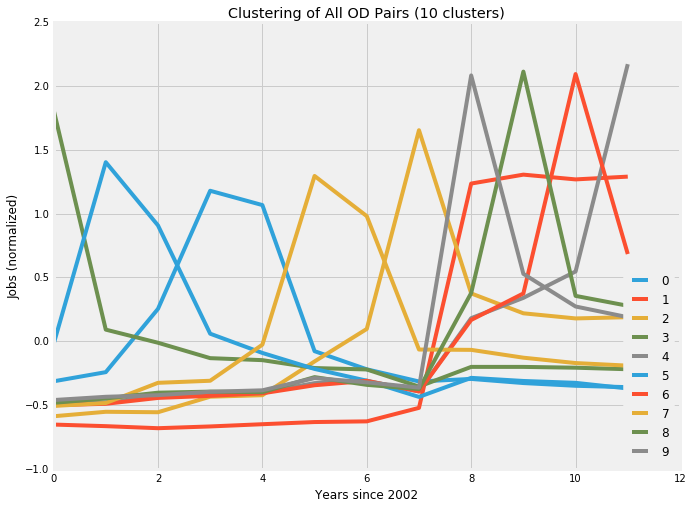

In [54]:
# perform clustering and plotting
fig = pl.figure(figsize=(10, 8))
pl.title('Clustering of All OD Pairs (10 clusters)')
pl.xlabel('Years since 2002')
pl.ylabel('Jobs (normalized)')

kmeans = KMeans(n_clusters=10)
kmeans.fit(matrix)
for i in range(10):
    pl.plot(kmeans.cluster_centers_[i], label = i)
    
pl.legend(loc='lower right')

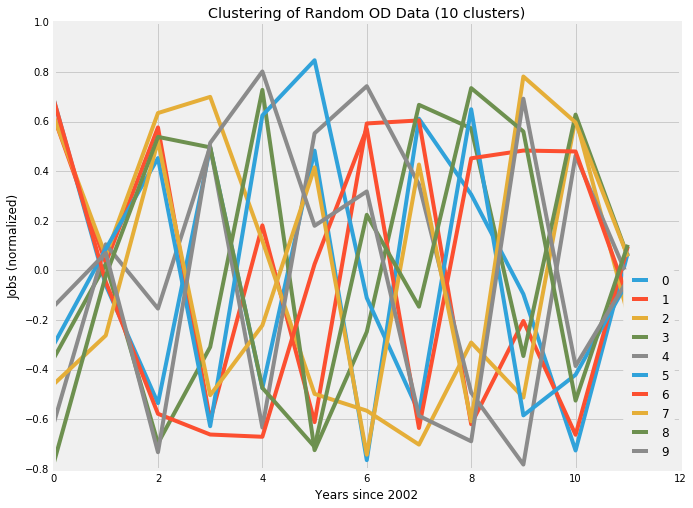

In [55]:
# perform clustering and plotting
fig = pl.figure(figsize=(10, 8))
pl.title('Clustering of Random OD Data (10 clusters)')
pl.xlabel('Years since 2002')
pl.ylabel('Jobs (normalized)')

kmeans = KMeans(n_clusters=10)
kmeans.fit(matrix_test)
for i in range(10):
    pl.plot(kmeans.cluster_centers_[i], label = i)
    
pl.legend(loc='lower right')